# U-Net test

In [1]:
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
saver = tf.train.import_meta_graph("./models/model.ckpt.meta")

In [3]:
sess = tf.InteractiveSession()

In [5]:
saver.restore(sess, "models/model.ckpt")

INFO:tensorflow:Restoring parameters from models/model.ckpt


In [7]:
X, mode = tf.get_collection("inputs")
pred = tf.get_collection("outputs")[0]

## Helper functions

In [8]:
def plot_image(image, title=None, **kwargs):
    """Plots a single image

    Args:
        image (2-D or 3-D array): image as a numpy array (H, W) or (H, W, C)
        title (str, optional): title for a plot
        **kwargs: keyword arguemtns for `plt.imshow`
    """
    shape = image.shape

    if len(shape) == 3:
        plt.imshow(image, **kwargs)
    elif len(shape) == 2:
        plt.imshow(image, **kwargs)
    else:
        raise TypeError(
            "2-D array or 3-D array should be given but {} was given".format(shape))

    if title:
        plt.title(title)


def plot_two_images(image_A, title_A, image_B, title_B, figsize=(15, 15), kwargs_1={}, kwargs_2={}):
    """Plots two images side by side"""
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plot_image(image_A, title=title_A, **kwargs_1)

    plt.subplot(1, 2, 2)
    plot_image(image_B, title=title_B, **kwargs_2)
    

def plot_three_images(image_A, image_B, image_C, figsize=(15, 15)):
    """Plots three images side by side"""
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 3, 1)
    plot_image(image_A)
    
    plt.subplot(1, 3, 2)
    plot_image(image_B)
    
    plt.subplot(1, 3, 3)
    plot_image(image_C)
    
    
def read_image(image_path, gray=False):
    """Returns an image array

    Args:
        image_path (str): Path to image.jpg

    Returns:
        3-D array: RGB numpy image array
    """
    if gray:
        return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    image = cv2.imread(image_path)    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## Pipeline function

In [17]:
def already_drawn_bbox(bbox, left_top, right_bot):
    
    for (a, b), (c, d) in bbox:
        
        if a <= left_top[0] <= c:
            if a <= right_bot[0] <= c:
                if b <= left_top[1] <= d:
                    if b <= left_top[1] <= d:
                        return True
    
    return False

In [33]:
def pipeline(image, threshold=0.9999, image_WH=(960, 640)):
    image = np.copy(image)
    H, W, C = image.shape
    
    if (W, H) != image_WH:
        image = cv2.resize(image, image_WH)
    
    mask_pred = sess.run(pred, feed_dict={X: np.expand_dims(image, 0),
                                          mode: False})
    
    mask_pred = np.squeeze(mask_pred)
    mask_pred = mask_pred > threshold
    
    labeled_heatmap, n_labels = label(mask_pred)
    
    bbox = []
    
    for i in range(n_labels):
        mask_i = labeled_heatmap == (i + 1)
        
        nonzero = np.nonzero(mask_i)
        
        nonzero_row = nonzero[0]
        nonzero_col = nonzero[1]
        
        left_top = min(nonzero_col), min(nonzero_row)
        right_bot = max(nonzero_col), max(nonzero_row)
        
        if not already_drawn_bbox(bbox, left_top, right_bot):
            image = cv2.rectangle(image, left_top, right_bot, color=(0, 255, 0), thickness=3)
        
            bbox.append((left_top, right_bot))
    
    return image

In [34]:
test_data = pd.read_csv("test.csv")
test_data.head()

,Frame,Mask
0,resize/1479504858405528025.jpg,mask/1479504858405528025.jpg
1,resize/1479499284525861927.jpg,mask/1479499284525861927.jpg
2,resize/1479498448468124924.jpg,mask/1479498448468124924.jpg
3,resize/1479504891903761044.jpg,mask/1479504891903761044.jpg
4,resize/1479499148018657352.jpg,mask/1479499148018657352.jpg


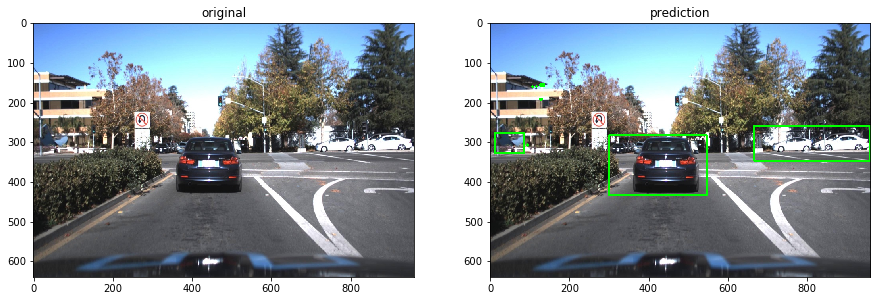

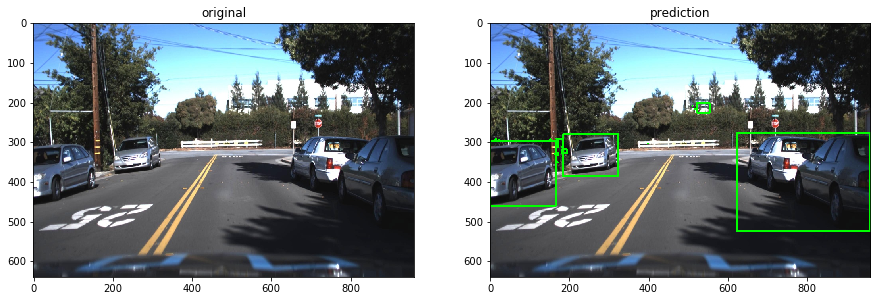

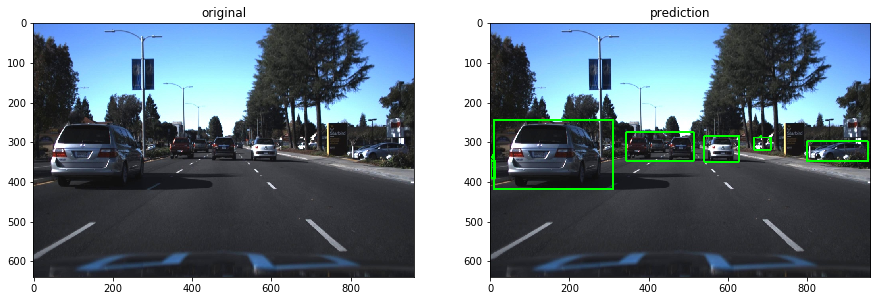

In [35]:
idx_list = np.random.randint(low=0, high=len(test_data), size=3)

for idx in idx_list:
    image_path = test_data.iloc[idx]["Frame"]
    image = read_image(image_path)

    plot_two_images(image, "original", pipeline(image), "prediction")

# Video Test

In [36]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
video = VideoFileClip("assets/video.mp4", audio=False)
output_video = "assets/processed.mp4"

In [38]:
processed_video = video.fl_image(pipeline)
%time processed_video.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video assets/processed.mp4
[MoviePy] Writing video assets/processed.mp4


100%|██████████| 485/485 [00:30<00:00, 12.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: assets/processed.mp4 

CPU times: user 46.3 s, sys: 8.62 s, total: 54.9 s
Wall time: 31.1 s


In [40]:
%time processed_video.write_gif("assets/processed.gif")


[MoviePy] Building file assets/processed.gif with imageio


100%|██████████| 485/485 [01:29<00:00,  4.72it/s]

CPU times: user 2min 28s, sys: 21.7 s, total: 2min 49s
Wall time: 1min 29s


In [39]:
HTML("""
<video width="960" height="640" controls>
  <source src="{0}">
</video>
""".format(output_video))